# Derivative benchmarks
This notebook implements the HS-SVD derivative estimation method in 1D and benchmarks its performance against the known ground truth derivative of the true function. It also performs benchmarks for the performance of the SKI and LOVE based finite difference estimates of the derivative. To execute this notebook, follow the steps below.

# Loading Required Packages and Helper Functions
If you would like to use Cuda, set gpu = True. Otherwise set gpu = False. 

Step 1: Run the following cells to import the required packages, data, and helper functions. Set the number of replicates desired.

Step 2: Run the following cells to implement the HS-SVD methods for mean and derivative estimation.

Step 3: Execute the cells under the method you wish to replicate/benchmark.

# Step 1

## Packages and helper functions

In [1]:
import os, gc, time, math, statistics, urllib.request

import numpy as np
import pandas as pd
import torch, gpytorch, psutil, pynvml
from scipy.io import loadmat
from matplotlib import pyplot as plt
from tqdm import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader

import gpytorch.models
from gpytorch.variational.nearest_neighbor_variational_strategy import NNVariationalStrategy
from gpytorch.mlls import DeepApproximateMLL
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal

gpu = True
n_replicates = 2
def log_memory():
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    meminfo = pynvml.nvmlDeviceGetMemoryInfo(handle)
    
    gpu_used = meminfo.used / 1024**2  # in MB
    torch_allocated = torch.cuda.max_memory_allocated() / 1024**2  # in MB
    sys_used = psutil.virtual_memory().used / 1024**3  # in GB
    
    print(f"[GPU] Used: {gpu_used:.2f} MB")
    print(f"[PyTorch] Max Allocated: {torch_allocated:.2f} MB")
    print(f"[System RAM] Used: {sys_used:.2f} GB")
    
    return gpu_used, torch_allocated, sys_used

def get_mem():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / (1024 ** 2)  # in MB


max_vram = 0
def vram_usage():
    global max_vram
    max_vram = max(max_vram, torch.cuda.memory_allocated())


# Loading Data
(note: must run the DataGenerator.Rmd file first)

In [2]:
data = pd.read_csv("Data/data_1D_100k_full.csv")


x  = torch.tensor(data['x'].values, dtype=torch.float64).unsqueeze(1)  # [N,1]
y  = torch.tensor(data['y'].values, dtype=torch.float64)              # [N]
dy = torch.tensor(data['dy'].values, dtype=torch.float64)             # [N]

def splitter(x_cpu, y_cpu, dy_cpu,
             n_train=80000, n_test=20000,
             random_state=None, move_to_gpu=True):
    N = x_cpu.shape[0]
    assert N == y_cpu.shape[0] == dy_cpu.shape[0], "All inputs must have same length"
    assert n_train + n_test <= N, "Not enough samples to split"

    rng = np.random.default_rng(random_state)
    indices = rng.permutation(N)

    train_idx = indices[:n_train]
    test_idx  = indices[n_train:n_train + n_test]

    train_x  = x_cpu[train_idx].contiguous()
    train_y  = y_cpu[train_idx].contiguous()
    train_dy = dy_cpu[train_idx].contiguous()
    test_x   = x_cpu[test_idx].contiguous()
    test_y   = y_cpu[test_idx].contiguous()
    test_dy  = dy_cpu[test_idx].contiguous()

    if move_to_gpu and torch.cuda.is_available():
        train_x, train_y, train_dy = train_x.cuda(), train_y.cuda(), train_dy.cuda()
        test_x,  test_y,  test_dy  = test_x.cuda(),  test_y.cuda(),  test_dy.cuda()

    return train_x, train_y, train_dy, test_x, test_y, test_dy

# Step 2: HS-SVD mean and derivative implementations

In [3]:
import torch
import torch.optim as optim

def phifunc(m, x):
    device = x.device
    dtype = x.dtype
    freq = torch.arange(1, m + 1, dtype=dtype, device=device)
    sin_values = torch.sin(torch.pi * freq.unsqueeze(1) * x.unsqueeze(0))
    phi = sin_values.transpose(0, 1)
    return phi

def phifunc_D(m, x):
    device = x.device
    dtype = x.dtype
    freq = torch.arange(1, m + 1, dtype=dtype, device=device)
    cos_vals = torch.cos(torch.pi * freq.unsqueeze(1) * x.unsqueeze(0))
    phi = (freq.unsqueeze(1) * torch.pi * cos_vals).transpose(0, 1)
    return phi


def lambdafunc(m, alpha, beta):
    device = alpha.device
    dtype = alpha.dtype
    freq = torch.arange(1, m + 1, dtype=dtype, device=device)
    values = (torch.pi**2) * (freq**2) + alpha**2
    lam = values**(-beta)
    lam = lam / torch.max(lam)
    return lam

def hssvd_predict_1d(x, y, x_new, init=torch.tensor([0.0, 0.0]), m=30, beta=1, 
                     train=True, lr=0.01, max_iter=1000, tol=1e-7):
    device = x.device
    dtype = x.dtype
    
    init = init.to(device=device, dtype=dtype)
    n = x.shape[0]
    Phi = phifunc(m, x)
    MM = Phi.shape[1]
    phi_T_phi = Phi.t() @ Phi
    phi_T_y = Phi.t() @ y
    sum_y2 = torch.sum(y**2)

    def nlik(log_params):
        eps = torch.exp(log_params[0])
        s2 = torch.exp(log_params[1])
        Lambda = lambdafunc(m, eps, beta)
        A = s2 * torch.diag(1.0 / Lambda) + phi_T_phi + 1e-10 * torch.eye(MM, device=device, dtype=dtype)
        
        A_cpu = A.cpu()
        L_cpu = torch.linalg.cholesky(A_cpu)
        phi_T_y_cpu = phi_T_y.cpu()
        sol = torch.cholesky_solve(phi_T_y_cpu.unsqueeze(1), L_cpu).squeeze(1).to(device)
        
        t1 = (sum_y2 - (phi_T_y @ sol)) / s2
        logdetA = 2 * torch.sum(torch.log(torch.diag(L_cpu).to(device)))
        t2 = (n - m) * torch.log(s2) + logdetA
        t3 = torch.sum(torch.log(Lambda))
        return t1 + t2 + t3

    if train:
        log_params = init.clone().detach().requires_grad_(True)
        optimizer = optim.Adam([log_params], lr=lr)
        prev_loss = None
        for iter_ in range(max_iter):
            optimizer.zero_grad()
            loss = nlik(log_params)
            loss.backward()
            optimizer.step()
            #print(f"Iter {iter_}: estimate = {log_params.data}, loss = {loss.item():.4f}", end="\r")
            if prev_loss is not None and torch.abs(loss - prev_loss) < tol * n:
                print(f"\nConverged after {iter_} iterations")
                break
            prev_loss = loss.item()
        out = log_params.detach()
        print("\nOptimized parameters (log-space):", out)
    else:
        out = init

    eps = torch.exp(out[0])
    s2 = torch.exp(out[1])
    Lambda = lambdafunc(m, eps, beta)
    A_final = s2 * torch.diag(1.0 / Lambda) + phi_T_phi + 1e-10 * torch.eye(MM, device=device, dtype=dtype)
    
    A_final_cpu = A_final.cpu()
    L_final_cpu = torch.linalg.cholesky(A_final_cpu)
    phi_T_y_cpu = phi_T_y.cpu()
    sol_final = torch.cholesky_solve(phi_T_y_cpu.unsqueeze(1), L_final_cpu).squeeze(1).to(device)
    
    K_inv_y = (1.0 / s2) * (y - Phi @ sol_final)
    Phi_new = phifunc(m, x_new)
    y_new = Phi_new @ (torch.diag(Lambda) @ (Phi.t() @ K_inv_y))
    
    return y_new

def phifunc(m, x):
    device = x.device
    dtype = x.dtype
    freq = torch.arange(1, m + 1, dtype=dtype, device=device)
    sin_values = torch.sin(torch.pi * freq.unsqueeze(1) * x.unsqueeze(0))
    phi = sin_values.transpose(0, 1)
    return phi


def phifunc_D(m, x):
    device = x.device
    dtype = x.dtype
    freq = torch.arange(1, m + 1, dtype=dtype, device=device)
    sin_values = torch.cos(torch.pi * freq.unsqueeze(1) * x.unsqueeze(0))
    phi = sin_values.transpose(0, 1)
    return phi


def lambdafunc(m, alpha, beta):
    device = alpha.device
    dtype = alpha.dtype
    freq = torch.arange(1, m + 1, dtype=dtype, device=device)
    values = (torch.pi**2) * (freq**2) + alpha**2
    lam = values**(-beta)
    lam = lam / torch.max(lam)
    return lam


def lambdafunc_D(m, alpha, beta):
    device = alpha.device
    dtype = alpha.dtype
    freq = torch.arange(1, m + 1, dtype=dtype, device=device)
    values = (torch.pi**2) * (freq**2) + alpha**2
    lam = values**(-beta)
    lam = lam / torch.max(lam)
    return torch.pi*freq*lam



def hssvd_predict_grad(x, y, x_new, init=torch.tensor([0.0, 0.0]), m=30, beta=1, 
                     train=True, lr=0.01, max_iter=1000, tol=1e-7):
    device = x.device
    dtype = x.dtype
    
    init = init.to(device=device, dtype=dtype)
    n = x.shape[0]
    Phi = phifunc(m, x)
    MM = Phi.shape[1]
    phi_T_phi = Phi.t() @ Phi
    phi_T_y = Phi.t() @ y
    sum_y2 = torch.sum(y**2)

    def nlik(log_params):
        eps = torch.exp(log_params[0])
        s2 = torch.exp(log_params[1])
        Lambda = lambdafunc(m, eps, beta)
        A = s2 * torch.diag(1.0 / Lambda) + phi_T_phi + 1e-10 * torch.eye(MM, device=device, dtype=dtype)
        
        A_cpu = A.cpu()
        L_cpu = torch.linalg.cholesky(A_cpu)
        phi_T_y_cpu = phi_T_y.cpu()
        sol = torch.cholesky_solve(phi_T_y_cpu.unsqueeze(1), L_cpu).squeeze(1).to(device)
        
        t1 = (sum_y2 - (phi_T_y @ sol)) / s2
        logdetA = 2 * torch.sum(torch.log(torch.diag(L_cpu).to(device)))
        t2 = (n - m) * torch.log(s2) + logdetA
        t3 = torch.sum(torch.log(Lambda))
        return t1 + t2 + t3

    if train:
        log_params = init.clone().detach().requires_grad_(True)
        optimizer = optim.Adam([log_params], lr=lr)
        prev_loss = None
        for iter_ in range(max_iter):
            optimizer.zero_grad()
            loss = nlik(log_params)
            loss.backward()
            optimizer.step()
            #print(f"Iter {iter_}: estimate = {log_params.data}, loss = {loss.item():.4f}", end="\r")
            if prev_loss is not None and torch.abs(loss - prev_loss) < tol * n:
                print(f"\nConverged after {iter_} iterations")
                break
            prev_loss = loss.item()
        out = log_params.detach()
        print("\nOptimized parameters (log-space):", out)
    else:
        out = init

    eps = torch.exp(out[0])
    s2 = torch.exp(out[1])
    Lambda = lambdafunc(m, eps, beta)
    A_final = s2 * torch.diag(1.0 / Lambda) + phi_T_phi + 1e-6 * torch.eye(MM, device=device, dtype=dtype)
    
    A_final_cpu = A_final.cpu()
    L_final_cpu = torch.linalg.cholesky(A_final_cpu)
    phi_T_y_cpu = phi_T_y.cpu()
    sol_final = torch.cholesky_solve(phi_T_y_cpu.unsqueeze(1), L_final_cpu).squeeze(1).to(device)
    
    K_inv_y = (1.0 / s2) * (y - Phi @ sol_final)
    Phi_new = phifunc_D(m, x_new)
    Lambda_D = lambdafunc_D(m, eps, beta)
    y_new = Phi_new @ (torch.diag(Lambda_D) @ (Phi.t() @ K_inv_y))
    
    return y_new



# Benchmarks

## HS-SVD derivative estimate benchmark


Converged after 376 iterations

Optimized parameters (log-space): tensor([ 4.2018, -1.2067])


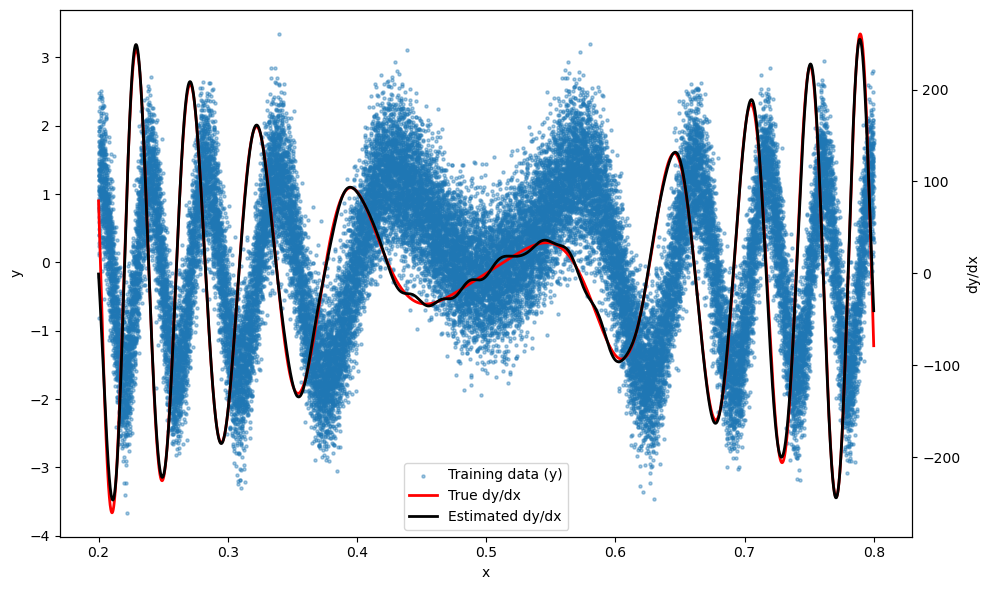

In [4]:
import torch
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

tx, ty, tdy, test_x, test_y, test_dy = splitter(
    x, y, dy,
    n_train=40_000,
    n_test=20_000,
    random_state=42,
    move_to_gpu=False
)

x_train = tx.squeeze().cpu().double()
y_train = ty.squeeze().cpu().double()
dy_true = tdy.squeeze().cpu().double()

dy_pred = hssvd_predict_grad(
    x_train, y_train, x_train,
    init=torch.tensor([0.0, 0.0], dtype=torch.float64),
    m=100, beta=2.5,
    train=True,
    lr=0.1
).cpu().squeeze().double()


idx             = torch.argsort(x_train)
x_sorted        = x_train[idx]
dy_true_sorted  = dy_true[idx]
dy_pred_sorted  = dy_pred[idx]

import torch
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.scatter(
    x_train.numpy(), y_train.numpy(),
    s=5, alpha=0.4, color="C0",
    label="Training data (y)"
)
ax1.set_xlabel("x")
ax1.set_ylabel("y", color="black")
ax1.tick_params(axis="y", labelcolor="black")


ax2 = ax1.twinx()
ax2.plot(
    x_sorted.numpy(), dy_true_sorted.numpy(),
    linestyle="-", linewidth=2, color="red",
    label="True dy/dx"
)
ax2.plot(
    x_sorted.numpy(), dy_pred_sorted.numpy(),
    linewidth=2, color="black",
    label="Estimated dy/dx"
)
ax2.set_ylabel("dy/dx", color="black")
ax2.tick_params(axis="y", labelcolor="black")


h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="best")

plt.tight_layout()
plt.show()



In [5]:
import time
import torch
from memory_profiler import memory_usage

torch.set_default_dtype(torch.float64)

#n_replicates = 11
results = []

for i in range(n_replicates):
    tx, ty, tdy, vx, vy, vdy = splitter(
        x, y, dy,
        n_train=80_000,
        n_test=20_000,
        random_state=i,
        move_to_gpu=False
    )
    x_train = tx.squeeze().cpu().double()
    y_train = ty.squeeze().cpu().double()
    dy_true = tdy.squeeze().cpu().double()

    var_dy = torch.var(dy_true, unbiased=False).item()
    init_vec = torch.tensor([0.0, 0.0], dtype=torch.float64)
    def target():
        return hssvd_predict_grad(
            x_train, y_train, x_train,
            init=init_vec, m=100, beta=2.5,
            train=True, lr = 0.5  # set True to include hyperparam fitting
        )

    t0 = time.time()
    peak_mem, dy_pred = memory_usage(
        (target,),
        max_usage=True,
        retval=True,
        interval=0.01
    )
    elapsed = time.time() - t0

    dy_pred = dy_pred.cpu().squeeze().double()
    mse  = torch.mean((dy_pred - dy_true)**2).item()
    nmse = mse / var_dy

    results.append({
        'replicate':   i+1,
        'mse':         mse,
        'nmse':        nmse,
        'time_s':      elapsed,
        'peak_ram_MB': peak_mem
    })

for r in results:
    print(
        f"Rep {r['replicate']:2d} — "
        f"MSE: {r['mse']:.5e}, "
        f"NMSE: {r['nmse']:.5e}, "
        f"Time: {r['time_s']:.4f}s, "
        f"Peak RAM: {r['peak_ram_MB']:.1f} MB"
    )

import numpy as np


mse_list      = [r['mse']          for r in results]
nmse_list     = [r['nmse']         for r in results]
time_list     = [r['time_s']       for r in results]
peak_ram_list = [r['peak_ram_MB']  for r in results]

n = len(results)

mean_mse      = np.mean(mse_list)
std_mse       = np.std(mse_list,      ddof=1)
mean_nmse     = np.mean(nmse_list)
std_nmse      = np.std(nmse_list,     ddof=1)
mean_time     = np.mean(time_list)
std_time      = np.std(time_list,     ddof=1)
mean_peak_ram = np.mean(peak_ram_list)
std_peak_ram  = np.std(peak_ram_list, ddof=1)

print(f"\n=== Averages & StdDev over {n} replicates ===")
print(f"Mean MSE:      {mean_mse:.6f}  ± {std_mse:.6f}")
print(f"Mean NMSE:     {mean_nmse:.6f}  ± {std_nmse:.6f}")
print(f"Mean Time:     {mean_time:.4f}s  ± {std_time:.4f}s")
print(f"Mean Peak RAM: {mean_peak_ram:.1f} MB  ± {std_peak_ram:.1f} MB")





Converged after 116 iterations

Optimized parameters (log-space): tensor([ 7.5192, -1.1975])

Converged after 105 iterations

Optimized parameters (log-space): tensor([ 7.5213, -1.2050])
Rep  1 — MSE: 1.38735e+01, NMSE: 1.15414e-03, Time: 0.4594s, Peak RAM: 764.5 MB
Rep  2 — MSE: 1.51451e+01, NMSE: 1.26629e-03, Time: 0.4368s, Peak RAM: 773.7 MB

=== Averages & StdDev over 2 replicates ===
Mean MSE:      14.509331  ± 0.899134
Mean NMSE:     0.001210  ± 0.000079
Mean Time:     0.4481s  ± 0.0160s
Mean Peak RAM: 769.1 MB  ± 6.4 MB


In [ ]:
mse_list      = [r['mse']          for r in results]
nmse_list     = [r['nmse']         for r in results]
time_list     = [r['time_s']       for r in results]
peak_ram_list = [r['peak_ram_MB']  for r in results]

n = len(results)

mean_mse      = np.mean(mse_list)
std_mse       = np.std(mse_list,      ddof=1)
mean_nmse     = np.mean(nmse_list)
std_nmse      = np.std(nmse_list,     ddof=1)
mean_time     = np.mean(time_list)
std_time      = np.std(time_list,     ddof=1)
mean_peak_ram = np.mean(peak_ram_list)
std_peak_ram  = np.std(peak_ram_list, ddof=1)


print(f"\n=== Averages & StdDev over {n} replicates ===")
print(f"Mean MSE:      {mean_mse:.6f}  ± {std_mse:.6f}")
print(f"Mean NMSE:     {mean_nmse:.6f}  ± {std_nmse:.6f}")
print(f"Mean Time:     {mean_time:.4f}s  ± {std_time:.4f}s")
print(f"Mean Peak RAM: {mean_peak_ram:.1f} MB  ± {std_peak_ram:.1f} MB")



=== Averages & StdDev over 2 replicates ===
Mean MSE:      14.509331  ± 0.899134
Mean NMSE:     0.001210  ± 0.000079
Mean Time:     0.4481s  ± 0.0160s
Mean Peak RAM: 769.1 MB  ± 6.4 MB


## SKI Finite Difference Benchmark

In [7]:
import tqdm, time, gc
import torch, gpytorch
from memory_profiler import memory_usage


torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x, 1.0 / 25.0)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=1),
                grid_size=grid_size, num_dims=1
            )
        )
    def forward(self, x):
        return gpytorch.distributions.MultivariateNormal(
            self.mean_module(x),
            self.covar_module(x)
        )

#n_replicates = 11
training_iterations = 32
n_train, n_test = 80_000, 20_00
random_state = 42

mse_l_ski = []
mse_deriv_l_ski = []
nmse_deriv_l_ski = []
time_l_ski = []

for rep in range(n_replicates):
    print(f"\n=== Replicate {rep + 1}/{n_replicates} ===")
    train_x, train_y, train_dy, test_x, test_y, _ = splitter(
        x, y, dy,
        n_train=n_train, n_test=n_test,
        random_state=random_state + rep,
        move_to_gpu=torch.cuda.is_available()
    )
    train_x = train_x.float().to(device)
    train_y = train_y.float().to(device)
    train_dy = train_dy.float().to(device)
    test_x  = test_x.float().to(device)
    test_y  = test_y.float().to(device)
    ram_before = get_mem() / (1024**2)
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
    likelihood = gpytorch.likelihoods.GaussianLikelihood().float().to(device)
    model = GPRegressionModel(train_x, train_y, likelihood).float().to(device)
    model.train(); likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model).to(device)
    def train_fn():
        for _ in tqdm.tqdm(range(training_iterations),
                           desc=f"Rep {rep+1} Training",
                           leave=False):
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            optimizer.step()
    start_time = time.time()
    peak_ram = memory_usage(
        (train_fn,),
        max_usage=True,
        retval=False,
        interval=0.1
    )
    elapsed = time.time() - start_time

    vram_peak = (
        torch.cuda.max_memory_allocated() / (1024**2)
        if torch.cuda.is_available() else None
    )
    ram_delta = peak_ram - ram_before
    model.eval(); likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred = likelihood(model(train_x)).mean.cpu()
    mse = torch.mean((pred - train_y.cpu()) ** 2).item()
    epsilon = 0.001
    train_x_eps = train_x + epsilon  
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_eps = likelihood(model(train_x_eps)).mean.cpu()

    deriv_fd = (pred_eps - pred) / epsilon
    true_dy = train_dy.cpu()
    mse_deriv = torch.mean((deriv_fd - true_dy)**2).item()
    true_dy_cpu = train_dy.cpu()
    var_true_dy = torch.var(true_dy_cpu, unbiased=False).item()
    nmse_deriv = mse_deriv / var_true_dy

    mse_l_ski.append(mse)
    mse_deriv_l_ski.append(mse_deriv)
    nmse_deriv_l_ski.append(nmse_deriv)
    time_l_ski.append(elapsed)

    print(
        f"Rep {rep+1}: "
        f"MSE={mse:.4f}, "
        f"Deriv MSE={mse_deriv:.4e}, "
        f"Norm. Deriv MSE={nmse_deriv:.4e}, "
        f"Time={elapsed:.2f}s, "
        f"RAM before={ram_before:.1f}MB, "
        f"peak={peak_ram:.1f}MB (Δ={ram_delta:.1f}MB)"
        + (f", VRAM peak={vram_peak:.1f}MB" if vram_peak is not None else "")
    )


    del model, likelihood
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()



=== Replicate 1/2 ===


Rep 1 Training:   0%|          | 0/32 [00:00<?, ?it/s]c:\ProgramData\miniconda3\envs\scaleGP\lib\site-packages\linear_operator\utils\sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
c:\ProgramData\miniconda3\envs\scaleGP\lib\site-packages\linear_operator\utils\sparse.py:66: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:646.)
  res = cls(index_tensor, value_tensor, interp_size)
c:\ProgramData\miniconda3\envs\scaleGP\lib\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The i

Rep 1: MSE=0.2988, Deriv MSE=5.2762e+03, Norm. Deriv MSE=4.3891e-01, Time=21.29s, RAM before=0.0MB, peak=1489.7MB (Δ=1489.7MB), VRAM peak=0.0MB

=== Replicate 2/2 ===


c:\ProgramData\miniconda3\envs\scaleGP\lib\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Rep 2: MSE=0.2989, Deriv MSE=4.8316e+03, Norm. Deriv MSE=4.0633e-01, Time=21.18s, RAM before=0.0MB, peak=1529.5MB (Δ=1529.5MB), VRAM peak=0.0MB


In [8]:
import numpy as np
mean_mse        = np.mean(mse_l_ski)
mean_mse_deriv  = np.mean(mse_deriv_l_ski)
mean_nmse_deriv = np.mean(nmse_deriv_l_ski)
mean_time       = np.mean(time_l_ski)
std_mse         = np.std(mse_l_ski,      ddof=1)
std_mse_deriv   = np.std(mse_deriv_l_ski,ddof=1)
std_nmse_deriv  = np.std(nmse_deriv_l_ski,ddof=1)
std_time        = np.std(time_l_ski,     ddof=1)

n = len(mse_l_ski)

print(f"\n=== Summary over {n} replicates ===")
print(f"  • Mean MSE:             {mean_mse:.6f}  ± {std_mse:.6f}")
print(f"  • Mean Deriv MSE:       {mean_mse_deriv:.6f}  ± {std_mse_deriv:.6f}")
print(f"  • Mean Norm. Deriv MSE: {mean_nmse_deriv:.6f}  ± {std_nmse_deriv:.6f}")
print(f"  • Mean Time (s):        {mean_time:.2f}  ± {std_time:.2f}")



=== Summary over 2 replicates ===
  • Mean MSE:             0.298827  ± 0.000092
  • Mean Deriv MSE:       5053.890381  ± 314.346598
  • Mean Norm. Deriv MSE: 0.422621  ± 0.023043
  • Mean Time (s):        21.23  ± 0.08


## LOVE Finite Difference Benchmark

In [9]:
import torch
import gpytorch
import tqdm
import time
import gc
import numpy as np
import psutil
class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self, input_dim):
        super().__init__()
        self.add_module('linear1', torch.nn.Linear(input_dim, 1000))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(1000, 500))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(500, 50))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(50, 1))

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=1)
            ),
            grid_size=100, num_dims=1
        )
        self.feature_extractor = LargeFeatureExtractor(input_dim=train_x.size(-1))

    def forward(self, x):
        projected_x = self.feature_extractor(x)
        projected_x = projected_x - projected_x.min(0)[0]
        projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


#n_replicates = 11
training_iterations = 25
n_train, n_test = 80_000, 100_000
random_state = 42
gpu = torch.cuda.is_available()
device = torch.device("cuda" if gpu else "cpu")

mse_l_love = []
time_l_love = []
vram_l_love = []
ram_l_love = []
mse_deriv_l_love = []
nmse_deriv_l_love = []

for rep in range(n_replicates):
    print(f"\n=== Replicate {rep + 1}/{n_replicates} ===")

    train_x, train_y, train_dy, test_x, test_y, _ = splitter(
        x, y, dy,
        n_train=n_train, n_test=n_test,
        random_state=random_state + rep,
        move_to_gpu=False
    )

    train_x = train_x.to(device).float()
    train_y = train_y.to(device).float()
    train_dy = train_dy.to(device).float()
    test_x  = test_x.to(device).float()
    test_y  = test_y.to(device).float()
    mem_begin = psutil.virtual_memory().used / (1024 ** 2)  # in MB
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device).float()
    model = GPRegressionModel(train_x, train_y, likelihood).to(device).float()
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model).to(device)

    if gpu:
        torch.cuda.reset_peak_memory_stats()

    start = time.time()
    iterator = tqdm.tqdm(range(training_iterations), desc=f"Train {rep + 1}")
    for it in iterator:
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        iterator.set_postfix(loss=loss.item())
    elapsed = time.time() - start

    mem_end = psutil.virtual_memory().used / (1024 ** 2)
    delta_ram = mem_end - mem_begin
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(train_x))
    means = observed_pred.mean.cpu()
    mse = torch.mean((means - train_y.cpu()) ** 2).item()
    epsilon = 0.001
    train_x_eps = train_x + epsilon
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred_eps = likelihood(model(train_x_eps))
    means_eps = observed_pred_eps.mean.cpu()
    deriv_fd = (means_eps - means) / epsilon
    true_dy = train_dy.cpu()
    mse_deriv = torch.mean((deriv_fd - true_dy) ** 2).item()

    var_true_dy = torch.var(true_dy, unbiased=False).item()
    nmse_deriv = mse_deriv / var_true_dy

    if gpu:
        peak_alloc = torch.cuda.max_memory_allocated() / 1024**2
    else:
        peak_alloc = 0.0

    mse_l_love.append(mse)
    mse_deriv_l_love.append(mse_deriv)
    nmse_deriv_l_love.append(nmse_deriv)
    time_l_love.append(elapsed)
    ram_l_love.append(delta_ram)
    vram_l_love.append(peak_alloc)

    print(
        f"LoVE Rep {rep+1}: "
        f"MSE={mse:.4f}, "
        f"Deriv MSE={mse_deriv:.4e}, "
        f"Norm. Deriv MSE={nmse_deriv:.4e}, "
        f"Time={elapsed:.2f}s, "
        f"RAM Δ={delta_ram:.1f}MB"
        + (f", VRAM peak={peak_alloc:.1f}MB" if gpu else "")
    )

    del model, likelihood
    gc.collect()
    if gpu:
        torch.cuda.empty_cache()



=== Replicate 1/2 ===


Train 1:   0%|          | 0/25 [00:00<?, ?it/s]c:\ProgramData\miniconda3\envs\scaleGP\lib\site-packages\linear_operator\utils\sparse.py:66: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\tensor\python_tensor.cpp:80.)
  res = cls(index_tensor, value_tensor, interp_size)
Train 1: 100%|██████████| 25/25 [00:05<00:00,  4.27it/s, loss=0.82] 
c:\ProgramData\miniconda3\envs\scaleGP\lib\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


LoVE Rep 1: MSE=0.2989, Deriv MSE=4.8339e+03, Norm. Deriv MSE=4.0212e-01, Time=5.85s, RAM Δ=1013.5MB, VRAM peak=1368.3MB

=== Replicate 2/2 ===


Train 2: 100%|██████████| 25/25 [00:04<00:00,  5.58it/s, loss=0.817]
c:\ProgramData\miniconda3\envs\scaleGP\lib\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


LoVE Rep 2: MSE=0.2989, Deriv MSE=4.9009e+03, Norm. Deriv MSE=4.1216e-01, Time=4.48s, RAM Δ=1.0MB, VRAM peak=1457.6MB


In [10]:
import numpy as np

mean_mse        = np.mean(mse_l_love)
mean_mse_deriv  = np.mean(mse_deriv_l_love)
mean_nmse_deriv = np.mean(nmse_deriv_l_love)
mean_time       = np.mean(time_l_love)

std_mse         = np.std(mse_l_love,         ddof=1)
std_mse_deriv   = np.std(mse_deriv_l_love,   ddof=1)
std_nmse_deriv  = np.std(nmse_deriv_l_love,  ddof=1)
std_time        = np.std(time_l_love,        ddof=1)

n = len(mse_l_love)

print(f"\n=== LoVE Summary over {n} replicates ===")
print(f"  • Mean MSE:             {mean_mse:.6f}  ± {std_mse:.6f}")
print(f"  • Mean Deriv MSE:       {mean_mse_deriv:.6f}  ± {std_mse_deriv:.6f}")
print(f"  • Mean Norm. Deriv MSE: {mean_nmse_deriv:.6f}  ± {std_nmse_deriv:.6f}")
print(f"  • Mean Time (s):        {mean_time:.2f}  ± {std_time:.2f}")



=== LoVE Summary over 2 replicates ===
  • Mean MSE:             0.298879  ± 0.000017
  • Mean Deriv MSE:       4867.421387  ± 47.410681
  • Mean Norm. Deriv MSE: 0.407140  ± 0.007096
  • Mean Time (s):        5.16  ± 0.97
